In [2]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.20.0
ipykernel        : 6.28.0
ipywidgets       : 7.6.5
jupyter_client   : 8.6.0
jupyter_core     : 5.5.0
jupyter_server   : 2.10.0
jupyterlab       : 4.0.11
nbclient         : 0.8.0
nbconvert        : 7.10.0
nbformat         : 5.9.2
notebook         : 7.0.8
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [3]:
!pip install kaggle

In [4]:
pip install torch torchvision matplotlib scikit-learn opencv-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import json
import requests
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


# Dataset Downloaded & Unzipped:

In [6]:
# Load Kaggle API credentials
with open('C:/Users/dheer/.kaggle/kaggle.json') as f:
    kaggle_json = json.load(f)

# Create a headers dict for the request
headers = {
    'Authorization': f"Bearer {kaggle_json['key']}"
}

# URL for the dataset
dataset_url = 'https://www.kaggle.com/api/v1/datasets/download/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone'

# Download the dataset
response = requests.get(dataset_url, headers=headers)

# Save the zip file
with open('ct-kidney-dataset-normal-cyst-tumor-and-stone.zip', 'wb') as f:
    f.write(response.content)

print("Dataset downloaded successfully!")

# Unzip the dataset
with zipfile.ZipFile('ct-kidney-dataset-normal-cyst-tumor-and-stone.zip', 'r') as zip_ref:
    zip_ref.extractall('./ct_kidney')

print("Dataset unzipped successfully!")


Dataset downloaded successfully!
Dataset unzipped successfully!


# Dataset Saved in the Root Directory & Subdirectory:

In [7]:
import os

# Define the path to the dataset directory
dataset_path = './ct_kidney'

# Walk through the directory structure
for root, dirs, files in os.walk(dataset_path):
    
    print(f"Root Directory: {root}")
    if dirs:
        print(f"Subdirectories: {dirs}")
    if files:
        print(f"Number of files: {len(files)}")
    print('-' * 40)


Root Directory: ./ct_kidney
Subdirectories: ['contrast_adjusted_dataset', 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', 'split_dataset']
Number of files: 1
----------------------------------------
Root Directory: ./ct_kidney\contrast_adjusted_dataset
Subdirectories: ['Cyst', 'Normal', 'Stone', 'Tumor']
----------------------------------------
Root Directory: ./ct_kidney\contrast_adjusted_dataset\Cyst
Number of files: 2967
----------------------------------------
Root Directory: ./ct_kidney\contrast_adjusted_dataset\Normal
Number of files: 4061
----------------------------------------
Root Directory: ./ct_kidney\contrast_adjusted_dataset\Stone
Number of files: 1101
----------------------------------------
Root Directory: ./ct_kidney\contrast_adjusted_dataset\Tumor
Number of files: 1826
----------------------------------------
Root Directory: ./ct_kidney\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
Subdirectories: ['CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone']
--------------------------------

In [8]:
# List class labels (subdirectory names)
class_labels = os.listdir(dataset_path)
print("Class Labels:", class_labels)


Class Labels: ['contrast_adjusted_dataset', 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone', 'kidneyData.csv', 'split_dataset']


# Importing all Images from the Dataset:

In [10]:
import os

# Define the path to the main dataset directory
dataset_path = './ct_kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# List class labels (subdirectory names)
class_labels = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Initialize a total image counter
total_images = 0

# Count images in each class
for label in class_labels:
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):  # Check if it's a directory
        num_images = len([f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        total_images += num_images
        print(f"Class '{label}' contains {num_images} images.")

# Print total number of images
print(f"Total number of images in the dataset: {total_images}")


Class 'Cyst' contains 3709 images.
Class 'Normal' contains 5077 images.
Class 'Stone' contains 1377 images.
Class 'Tumor' contains 2283 images.
Total number of images in the dataset: 12446


# Displaying Class Images of Different Classes

Class Labels: ['Cyst', 'Normal', 'Stone', 'Tumor']
Displaying images for class: Cyst


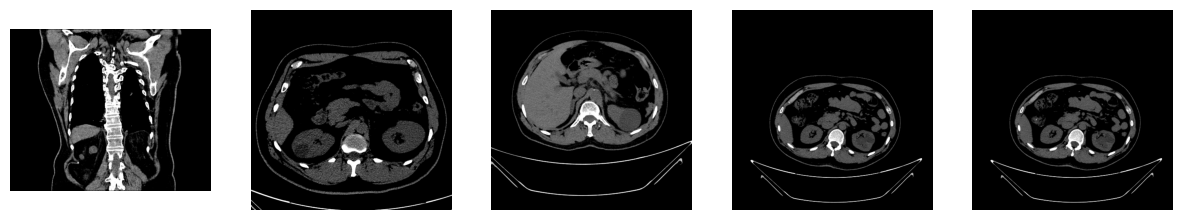

Displaying images for class: Normal


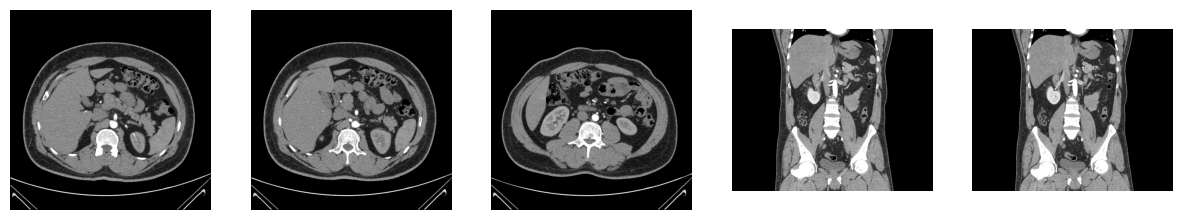

Displaying images for class: Stone


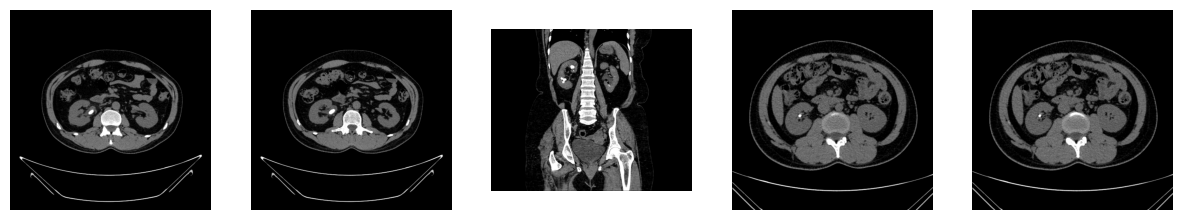

Displaying images for class: Tumor


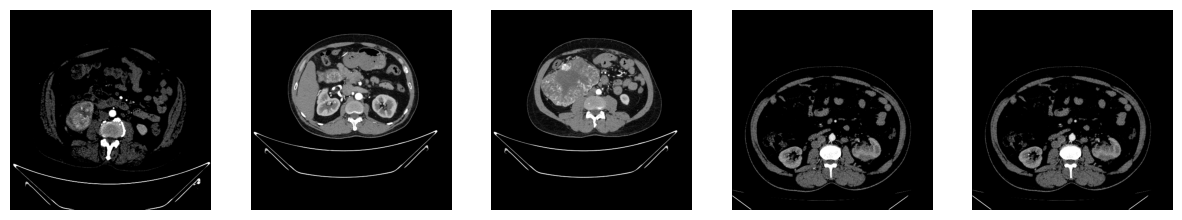

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to the main dataset directory
dataset_path = './ct_kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# List class labels (subdirectory names)
class_labels = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
print("Class Labels:", class_labels)

# Visualize sample images from each class
for label in class_labels:
    label_path = os.path.join(dataset_path, label)
    sample_images = [f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]  # first 5 images
    print(f"Displaying images for class: {label}")
    
    if len(sample_images) == 0:
        print(f"No images found in class: {label}")
        continue
    
    # Create subplots
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(label_path, img_name)
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    plt.show()


# Classes Split into Train, Test and Validation: 

In [12]:
import os
import random
import shutil

# Define paths
base_path = './ct_kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
output_base = './ct_kidney/split_dataset'

# Create split directories
splits = ['train', 'validation', 'test']
for split in splits:
    for class_label in os.listdir(base_path):
        class_path = os.path.join(output_base, split, class_label)
        os.makedirs(class_path, exist_ok=True)

# Split dataset
random.seed(42)  # For reproducibility

for class_label in os.listdir(base_path):
    class_dir = os.path.join(base_path, class_label)
    if os.path.isdir(class_dir):  # it's a directory
        # Filter and shuffle images
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(os.path.join(class_dir, f))]
        random.shuffle(images)

        # Compute split sizes
        total_images = len(images)
        train_count = int(0.8 * total_images)
        val_count = int(0.1 * total_images)
        test_count = total_images - train_count - val_count

        # Split images
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        # Copy images to respective folders
        for img in train_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_base, 'train', class_label, img))
        for img in val_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_base, 'validation', class_label, img))
        for img in test_images:
            shutil.copy(os.path.join(class_dir, img), os.path.join(output_base, 'test', class_label, img))

        print(f"Class '{class_label}' split into train: {len(train_images)}, validation: {len(val_images)}, test: {len(test_images)}")


Class 'Cyst' split into train: 2967, validation: 370, test: 372
Class 'Normal' split into train: 4061, validation: 507, test: 509
Class 'Stone' split into train: 1101, validation: 137, test: 139
Class 'Tumor' split into train: 1826, validation: 228, test: 229


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

# K-Fold Cross Validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Training fold {fold+1}...")

    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define model (use the same model you've already defined)
    model = tf.keras.models.Sequential([
        # Add your model layers here (e.g., Conv2D, Dense layers)
    ])

    # Compile the model (same as before)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the current fold
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model on the validation fold
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    fold_accuracies.append(val_accuracy)

    print(f"Fold {fold+1} validation accuracy: {val_accuracy}")

# Calculate average accuracy across all folds
avg_accuracy = np.mean(fold_accuracies)
print(f"Average Validation Accuracy across all folds: {avg_accuracy}")


# Resizing Using PIL Library

In [13]:
from PIL import Image
import os

# Define the path to the dataset (split into train, validation, and test folders)
dataset_path = './ct_kidney/split_dataset'
target_size = (224, 224)  # Desired size for resizing

# Function to resize images
def resize_images(folder_path, target_size):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        # Resize the image and save it back
                        img_resized = img.resize(target_size, Image.Resampling.LANCZOS)
                        img_resized.save(file_path)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

# Resize images in each subset (train, validation, test)
for split in ['train', 'validation', 'test']:
    split_path = os.path.join(dataset_path, split)
    print(f"Resizing images in {split_path}...")
    resize_images(split_path, target_size)
    print(f"Finished resizing images in {split_path}.")


Resizing images in ./ct_kidney/split_dataset\train...
Finished resizing images in ./ct_kidney/split_dataset\train.
Resizing images in ./ct_kidney/split_dataset\validation...
Finished resizing images in ./ct_kidney/split_dataset\validation.
Resizing images in ./ct_kidney/split_dataset\test...
Finished resizing images in ./ct_kidney/split_dataset\test.


# Images Resized 

In [14]:

# Function to check image sizes
def check_image_sizes(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in random.sample(files, min(5, len(files))):  # Check up to 5 random files
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        print(f"Image: {file_path}, Size: {img.size}")
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

# Check sizes for each subset (train, validation, test)
for split in ['train', 'validation', 'test']:
    split_path = os.path.join(dataset_path, split)
    print(f"Checking image sizes in {split_path}...")
    check_image_sizes(split_path)


Checking image sizes in ./ct_kidney/split_dataset\train...
Image: ./ct_kidney/split_dataset\train\Cyst\Cyst- (1697).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Cyst\Cyst- (811).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Cyst\Cyst- (3146).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Cyst\Cyst- (1366).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Cyst\Cyst- (560).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Normal\Normal- (1434).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Normal\Normal- (82).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Normal\Normal- (4317).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Normal\Normal- (2070).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Normal\Normal- (509).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Stone\Stone- (262).jpg, Size: (224, 224)
Image: ./ct_kidney/split_dataset\train\Stone\Stone- (132

In [15]:
import os
import cv2
from PIL import Image
import numpy as np

# Define paths
dataset_path = './ct_kidney/split_dataset'
output_path = './ct_kidney/smoothed_dataset'

# Create output directories
splits = ['train', 'validation', 'test']
for split in splits:
    split_output_path = os.path.join(output_path, split)
    os.makedirs(split_output_path, exist_ok=True)

# Function to apply Gaussian filter
def apply_gaussian_filter(input_path, output_path, kernel_size=(5, 5)):
    for root, dirs, files in os.walk(input_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    # Read the image
                    img = cv2.imread(file_path)

                    # Apply Gaussian filter
                    smoothed_img = cv2.GaussianBlur(img, kernel_size, 0)

                    # Save the filtered image
                    relative_path = os.path.relpath(root, input_path)
                    save_dir = os.path.join(output_path, relative_path)
                    os.makedirs(save_dir, exist_ok=True)
                    save_path = os.path.join(save_dir, file)
                    cv2.imwrite(save_path, smoothed_img)

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

# Apply Gaussian filter to each subset
for split in splits:
    split_input_path = os.path.join(dataset_path, split)
    split_output_path = os.path.join(output_path, split)
    print(f"Applying Gaussian filter to {split_input_path}...")
    apply_gaussian_filter(split_input_path, split_output_path)
    print(f"Finished applying Gaussian filter to {split_input_path}.")


Applying Gaussian filter to ./ct_kidney/split_dataset\train...
Finished applying Gaussian filter to ./ct_kidney/split_dataset\train.
Applying Gaussian filter to ./ct_kidney/split_dataset\validation...
Finished applying Gaussian filter to ./ct_kidney/split_dataset\validation.
Applying Gaussian filter to ./ct_kidney/split_dataset\test...
Finished applying Gaussian filter to ./ct_kidney/split_dataset\test.


# Normalization 

In [26]:
import os
from PIL import Image
import numpy as np

# Define the dataset path
dataset_path = './ct_kidney/split_dataset'

# Function to normalize images
def normalize_images(input_path, output_path=None):
    for root, dirs, files in os.walk(input_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        # Convert image to array
                        img_array = np.array(img).astype('float32')
                        
                        # Normalize pixel values to [0, 1]
                        img_array /= 255.0
                        
                        # Convert back to PIL image
                        normalized_img = Image.fromarray((img_array * 255).astype('uint8'))
                        
                        # Save normalized image
                        save_path = file_path if output_path is None else file_path.replace(input_path, output_path)
                        os.makedirs(os.path.dirname(save_path), exist_ok=True)
                        normalized_img.save(save_path)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

# Normalize images for each split (train, validation, test)
for split in ['train', 'validation', 'test']:
    split_path = os.path.join(dataset_path, split)
    print(f"Normalizing images in {split_path}...")
    normalize_images(split_path)


Normalizing images in ./ct_kidney/split_dataset\train...
Normalizing images in ./ct_kidney/split_dataset\validation...
Normalizing images in ./ct_kidney/split_dataset\test...


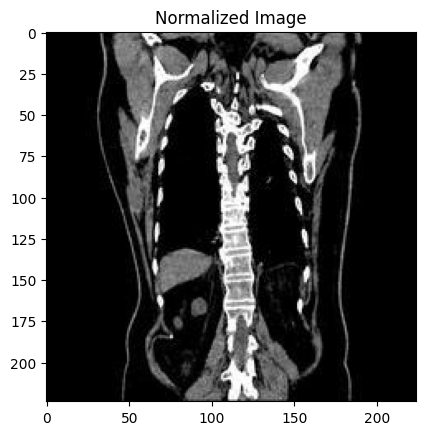

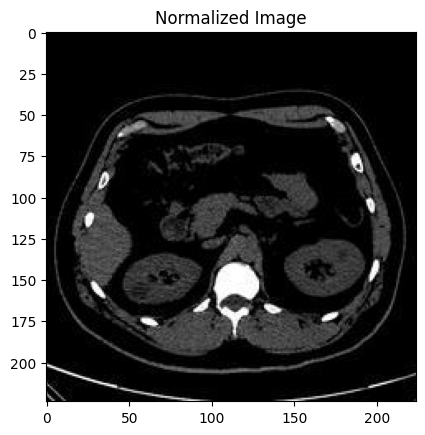

In [27]:
image_path = './ct_kidney/split_dataset/train/Cyst/Cyst- (1).jpg'  # Path to a specific image file
image_path1 = './ct_kidney/split_dataset/train/Cyst/Cyst- (3).jpg'
with Image.open(image_path) as img:
    plt.imshow(img)
    plt.axis('on')
    plt.title("Normalized Image")
    plt.show()

with Image.open(image_path1) as img1:
    plt.imshow(img1)
    plt.axis('on')
    plt.title("Normalized Image")
    plt.show()


# Pixel Range across Dataset

In [28]:
import os
total_min, total_max = float('inf'), float('-inf')

for root, dirs, files in os.walk('./ct_kidney/split_dataset'):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                img_array = np.array(img).astype('float32') / 255.0
                total_min = min(total_min, img_array.min())
                total_max = max(total_max, img_array.max())

print(f"Pixel range across dataset: Min={total_min}, Max={total_max}")


Pixel range across dataset: Min=0.0, Max=1.0


# Data Augmentation

In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np

# Define paths
base_path = './ct_kidney/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
output_base = './augmented_dataset'

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Process each class folder
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)
    if os.path.isdir(class_path):
        # Create corresponding output directory
        output_class_dir = os.path.join(output_base, class_folder)
        os.makedirs(output_class_dir, exist_ok=True)

        # Filter image files
        img_files = [f for f in os.listdir(class_path) if f.lower().endswith(valid_extensions)]

        # Process each image
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            try:
                # Open and preprocess the image
                with Image.open(img_path) as img:
                    img = img.resize((224, 224))  # Resize to standard dimensions
                    img_array = np.array(img)
                    
                    # Ensure RGB format
                    if len(img_array.shape) == 2:  # Grayscale image
                        img_array = np.stack((img_array,) * 3, axis=-1)
                    
                    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

                    # Generate and save augmented images
                    for i, batch in enumerate(datagen.flow(
                        img_array,
                        batch_size=5,  # Process in batches
                        save_to_dir=output_class_dir,
                        save_prefix='aug',
                        save_format='jpeg'
                    )):
                        break  # One batch of size 5 is enough

            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

print("Data augmentation completed.")


Data augmentation completed.


# Visuals Data Augmentation 

Saved image: aug_0.jpeg
Saved image: aug_1.jpeg
Saved image: aug_2.jpeg
Saved image: aug_3.jpeg
Saved image: aug_4.jpeg
Saved image: aug_5.jpeg
Augmented files saved: ['aug_0_1037.jpeg', 'aug_0_1040.jpeg', 'aug_0_1075.jpeg', 'aug_0_1156.jpeg', 'aug_0_1201.jpeg', 'aug_0_1252.jpeg', 'aug_0_1285.jpeg', 'aug_0_1356.jpeg', 'aug_0_1396.jpeg', 'aug_0_1416.jpeg', 'aug_0_1538.jpeg', 'aug_0_1594.jpeg', 'aug_0_1611.jpeg', 'aug_0_1691.jpeg', 'aug_0_173.jpeg', 'aug_0_1950.jpeg', 'aug_0_2002.jpeg', 'aug_0_2044.jpeg', 'aug_0_2154.jpeg', 'aug_0_2175.jpeg', 'aug_0_2202.jpeg', 'aug_0_2206.jpeg', 'aug_0_2219.jpeg', 'aug_0_2234.jpeg', 'aug_0_2445.jpeg', 'aug_0_2953.jpeg', 'aug_0_2993.jpeg', 'aug_0_3132.jpeg', 'aug_0_3205.jpeg', 'aug_0_322.jpeg', 'aug_0_3349.jpeg', 'aug_0_3351.jpeg', 'aug_0_3396.jpeg', 'aug_0_3484.jpeg', 'aug_0_3495.jpeg', 'aug_0_3539.jpeg', 'aug_0_3564.jpeg', 'aug_0_36.jpeg', 'aug_0_3621.jpeg', 'aug_0_3636.jpeg', 'aug_0_3668.jpeg', 'aug_0_3700.jpeg', 'aug_0_3722.jpeg', 'aug_0_378.jpeg', '

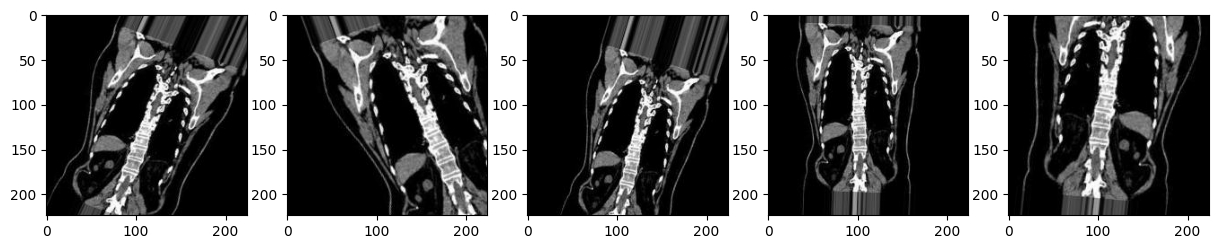

In [3]:
import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the directory for saving augmented images
augmented_dir = './augmented'

# Create the directory if it doesn't exist
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# Example image path
image_path = './ct_kidney/split_dataset/train/Cyst/Cyst- (1).jpg'

# Applying augmentation to the entire dataset


# Load and preprocess the image
with Image.open(image_path) as img:
    img_array = np.array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the generator

# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply augmentation and save the augmented images
for i, batch in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='jpeg')):
    print(f"Saved image: aug_{i}.jpeg")  # Print the file name of the saved image
    if i >= 5:  # Generate only 5 augmented images
        break

# Check the files saved in the augmented directory
augmented_files = os.listdir(augmented_dir)
print(f"Augmented files saved: {augmented_files}")

# Plot the augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    augmented_img_path = augmented_files[i]
    augmented_img = Image.open(os.path.join(augmented_dir, augmented_img_path))
    axes[i].imshow(augmented_img)
    axes[i].axis('on')
plt.show()


# Plot samples of each class to understand visual differences:

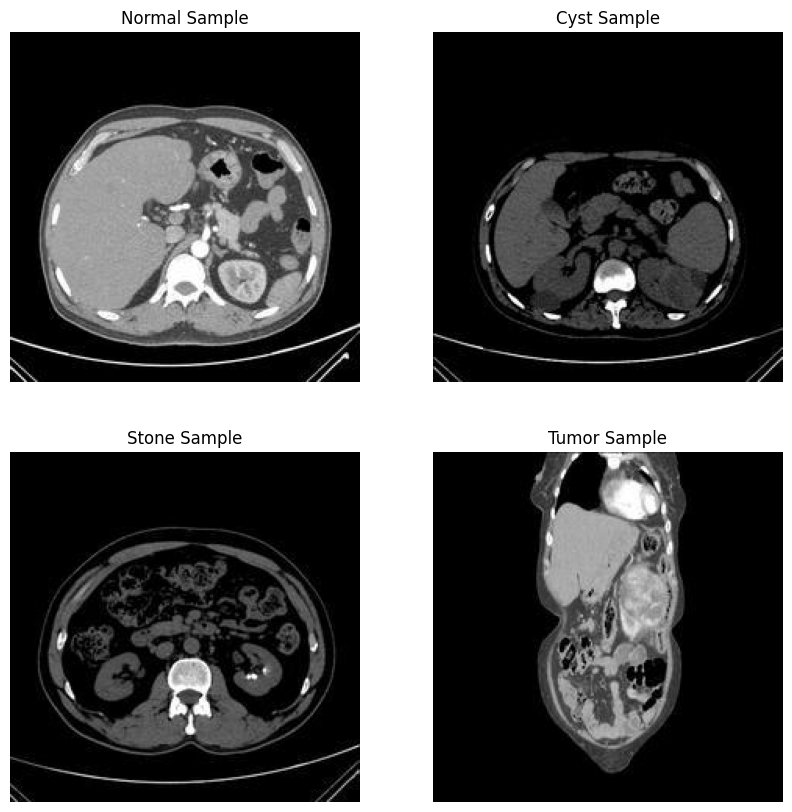

In [4]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the directory for each class
class_dirs = {
    'Normal': './ct_kidney/split_dataset/train/Normal',
    'Cyst': './ct_kidney/split_dataset/train/Cyst',
    'Stone': './ct_kidney/split_dataset/train/Stone',
    'Tumor': './ct_kidney/split_dataset/train/Tumor'
}

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Iterate over the classes
for i, (class_name, class_dir) in enumerate(class_dirs.items()):
    # Get a random image from the class directory
    img_filename = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_filename)

    # Load the image and plot it
    with Image.open(img_path) as img:
        axes[i // 2, i % 2].imshow(img)
        axes[i // 2, i % 2].axis('off')
        axes[i // 2, i % 2].set_title(f'{class_name} Sample')

# Show the plot
plt.show()


# Check the class distributions and identify any imbalances:

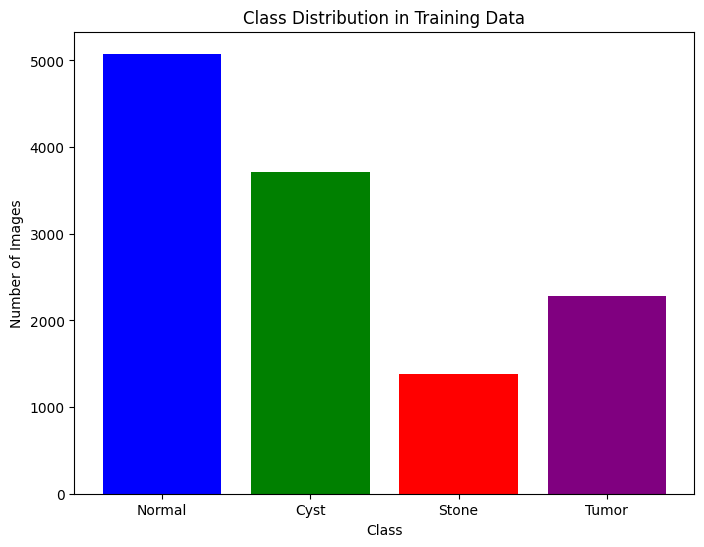

Class Distribution:
Normal: 5077 images
Cyst: 3709 images
Stone: 1377 images
Tumor: 2283 images


In [5]:
import os
import matplotlib.pyplot as plt

# Define the directory for each class
class_dirs = {
    'Normal': './ct_kidney/split_dataset/train/Normal',
    'Cyst': './ct_kidney/split_dataset/train/Cyst',
    'Stone': './ct_kidney/split_dataset/train/Stone',
    'Tumor': './ct_kidney/split_dataset/train/Tumor'
}

# Initialize a dictionary to store class counts
class_counts = {}

# Count the number of images in each class
for class_name, class_dir in class_dirs.items():
    num_images = len(os.listdir(class_dir))
    class_counts[class_name] = num_images

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.show()

# Display the counts for each class
print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


# Visualization for Data Imbalance: 

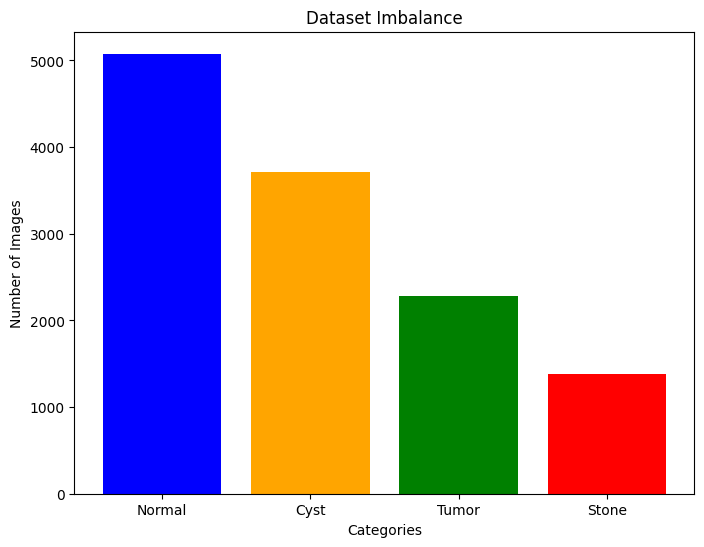

In [6]:
import matplotlib.pyplot as plt

# Sample dataset distribution
categories = ['Normal', 'Cyst', 'Tumor', 'Stone']
counts = [5077, 3709, 2283, 1377]

# Create a bar graph
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
plt.title('Dataset Imbalance')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.show()


# Annotated images representing all classes in the dataset:

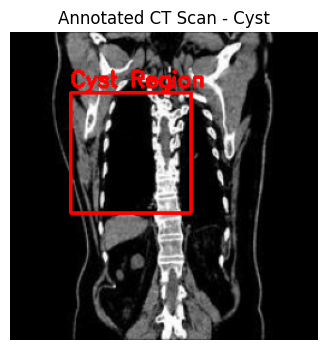

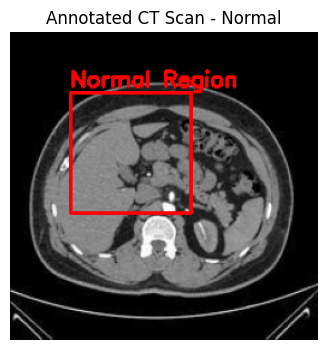

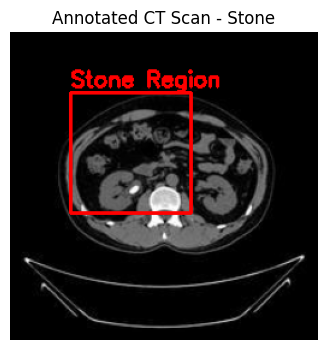

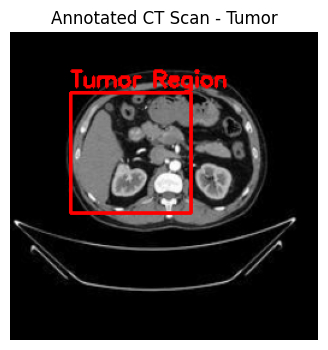

In [7]:
import cv2
from matplotlib import pyplot as plt

# Define the image paths
image_paths = {
    "Cyst": './ct_kidney/split_dataset/train/Cyst/Cyst- (1).jpg',
    "Normal": "./ct_kidney/split_dataset/train/Normal/Normal- (2).jpg",
    "Stone": "./ct_kidney/split_dataset/train/Stone/Stone- (3).jpg",
    "Tumor": "./ct_kidney/split_dataset/train/Tumor/Tumor- (4).jpg"
}

# Set the desired size for resizing (e.g., 256x256 pixels)
resize_dim = (256, 256)

# Loop through the images and annotate each
for class_name, image_path in image_paths.items():
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if the image was successfully loaded
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        continue
    
    # Resize the image
    image_resized = cv2.resize(image, resize_dim)
    
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

    # Annotate the image
    annotated_image = image_rgb.copy()
    cv2.rectangle(annotated_image, (50, 50), (150, 150), (255, 0, 0), 2)  # Example rectangle
    cv2.putText(annotated_image, f'{class_name} Region', (50, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Display the annotated image
    plt.figure(figsize=(4, 4))  # figure size for resized images
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title(f'Annotated CT Scan - {class_name}')
    plt.show()


# Class Weight Balance:

In [8]:
from sklearn.utils import class_weight
import numpy as np

# Define the class labels for your training data
class_labels = ['Normal', 'Cyst', 'Stone', 'Tumor']
labels = []

# Iterate over your training data and assign the corresponding label index
for class_name in class_labels:
    class_dir = class_dirs[class_name]
    for img_name in os.listdir(class_dir):
        if img_name.endswith('.jpg'):
            labels.append(class_labels.index(class_name))  # Append the class index

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(labels), 
    y=labels
)

# Create a dictionary for class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_labels))}

# Print the class weights
print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.6128619263344495, 1: 0.8389053653275815, 2: 2.259622367465505, 3: 1.3628996933858957}


In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Example class sample counts
class_counts = {
    'Cyst': 2967,
    'Normal': 4061,
    'Stone': 1101,
    'Tumor': 1826
}

# Compute class weights
class_labels = list(range(len(class_counts)))  
class_samples = list(class_counts.values())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=np.hstack([[label] * count for label, count in zip(class_labels, class_samples)])
)

# Convert to dictionary for training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.8388102460397708, 1: 0.612841664614627, 2: 2.260445049954587, 3: 1.3629518072289157}


In [14]:
minority_class_dir = './ct_kidney/split_dataset/train/Stone'
augmented_dir = './augmented_dataset/Stone'

for img_name in os.listdir(minority_class_dir):
    img_path = os.path.join(minority_class_dir, img_name)
    with Image.open(img_path) as img:
        img_array = np.array(img).reshape((1,) + img.size + (3,))
        for i, batch in enumerate(datagen.flow(img_array, batch_size=1, save_to_dir=augmented_dir, save_format='jpeg')):
            if i >= 5:  # Generate 5 augmented images
                break


# Contrast Adjustment with CLAHE(Contrast Limited Adaptive Histogram Equalization):

In [15]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Paths for input dataset and output directory
input_dir = './ct_kidney/split_dataset/train'
output_dir = './ct_kidney/contrast_adjusted_dataset'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# CLAHE settings
clip_limit = 2.0
tile_grid_size = (8, 8)
clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

# Process each class directory
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    output_class_path = os.path.join(output_dir, class_name)
    
    os.makedirs(output_class_path, exist_ok=True)  # Create output class directory
    
    print(f"Processing class: {class_name}")
    
    # Process each image in the class
    for image_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        input_image_path = os.path.join(class_path, image_name)
        output_image_path = os.path.join(output_class_path, image_name)
        
        # Read the image in grayscale
        img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping {image_name}: Unable to read.")
            continue
        
        # Apply CLAHE
        enhanced_img = clahe.apply(img)
        
        # Save the enhanced image
        cv2.imwrite(output_image_path, enhanced_img)

print("Contrast adjustment completed for the entire dataset!")


Processing class: Cyst


Processing Cyst: 100%|████████████████████████████████████████████████████████████| 3709/3709 [00:09<00:00, 400.16it/s]


Processing class: Normal


Processing Normal: 100%|██████████████████████████████████████████████████████████| 5077/5077 [00:10<00:00, 480.25it/s]


Processing class: Stone


Processing Stone: 100%|███████████████████████████████████████████████████████████| 1377/1377 [00:02<00:00, 497.90it/s]


Processing class: Tumor


Processing Tumor: 100%|███████████████████████████████████████████████████████████| 2283/2283 [00:04<00:00, 518.14it/s]

Contrast adjustment completed for the entire dataset!


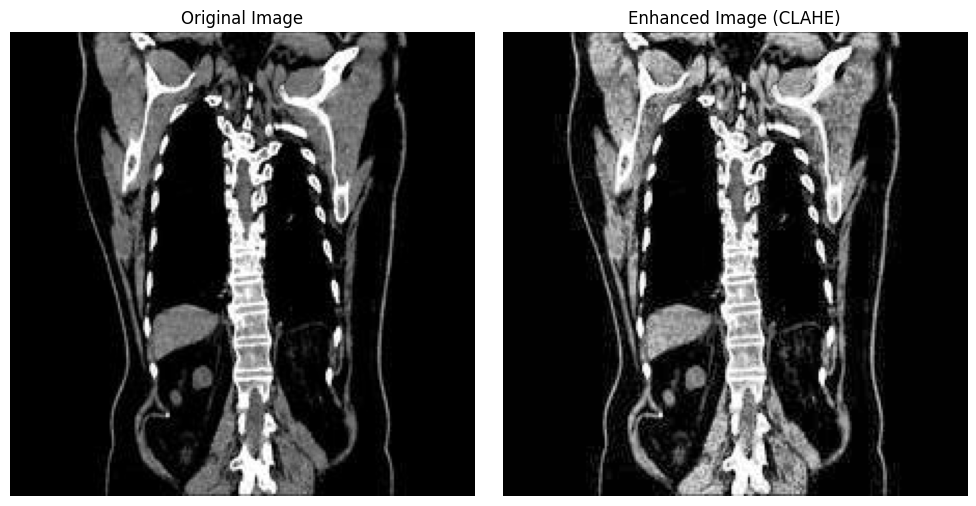

In [37]:
# Example image path
example_image_path = './ct_kidney/split_dataset/train/Cyst/Cyst- (1).jpg'

# Load the image
img = cv2.imread(example_image_path, cv2.IMREAD_GRAYSCALE)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_img = clahe.apply(img)

# Plot the original and enhanced images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Enhanced Image (CLAHE)")
plt.imshow(enhanced_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# Calculate the Mean and Standard Deviation using Pixel Intensity Distribution:

Mean per channel for Cyst (R, G, B): [0.10637958 0.10637958 0.10637958]
Mean per channel for Normal (R, G, B): [0.17671099 0.17671099 0.17671099]
Mean per channel for Stone (R, G, B): [0.14052737 0.14052737 0.14052737]
Mean per channel for Tumor (R, G, B): [0.14433601 0.14433601 0.14433601]


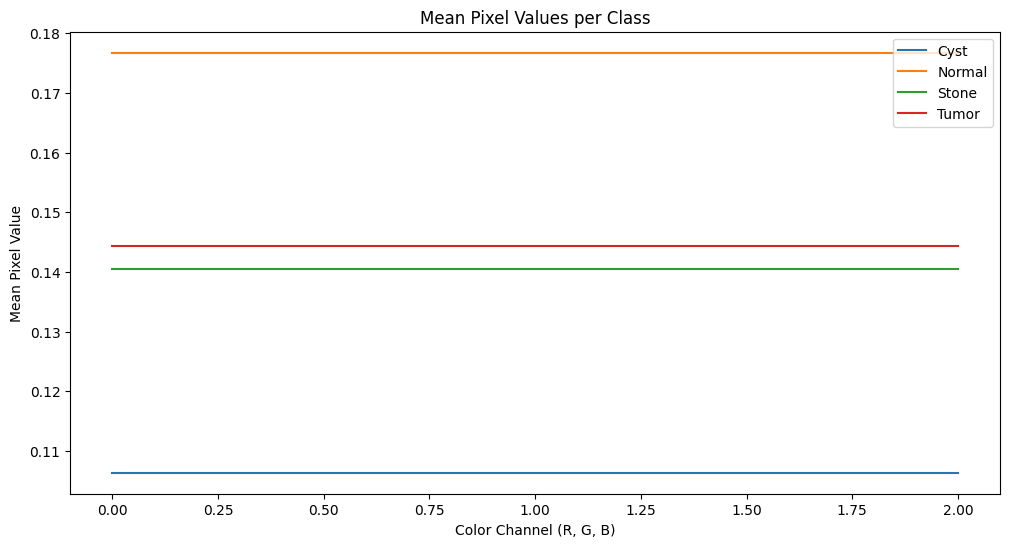

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Directory for dataset 
dataset_dir = './ct_kidney/split_dataset/train' 

# Initialize dictionary to store pixel sums and counts per class
class_sums = {}
class_counts = {}

# Load images and accumulate pixel sums by class
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    if os.path.isdir(class_path):
        class_sums[class_folder] = np.zeros(3)  # R, G, B channel sums
        class_counts[class_folder] = 0
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                img_array = np.array(img).astype('float32') / 255.0  # Normalize to [0, 1]
                
                # Accumulate the sum of pixel values for each channel
                class_sums[class_folder] += np.sum(img_array, axis=(0, 1))  # Sum per channel
                class_counts[class_folder] += img_array.shape[0] * img_array.shape[1]  # Total pixels

# Calculate mean per class
class_means = {}
for class_name in class_sums:
    class_means[class_name] = class_sums[class_name] / class_counts[class_name]

# Print the results
for class_name, mean_values in class_means.items():
    print(f"Mean per channel for {class_name} (R, G, B): {mean_values}")

# Plot the pixel mean distribution for each class
plt.figure(figsize=(12, 6))
for class_name, mean_values in class_means.items():
    plt.plot(mean_values, label=class_name)

plt.title("Mean Pixel Values per Class")
plt.xlabel("Color Channel (R, G, B)")
plt.ylabel("Mean Pixel Value")
plt.legend()
plt.show()


# Applying EfficientNetB0 Libraries :

In [27]:
#pip install transformers tensorflow


In [17]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



In [18]:
train_dir = './ct_kidney/split_dataset/train'
val_dir = './ct_kidney/split_dataset/validation'
test_dir = './ct_kidney/split_dataset/test'


# Analyzing Image Dimensions, batch size and Data Generation:

In [19]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 12446 images belonging to 4 classes.
Found 11024 images belonging to 4 classes.
Found 7100 images belonging to 4 classes.


# Applying Efficient Net B0 Model:

In [20]:
# Load EfficientNetB0 with pre-trained weights, excluding the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the base model
base_model.trainable = True
for layer in base_model.layers[:150]:  # Freeze earlier layers
    layer.trainable = False

# Add custom layers for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)  # Reduce dropout
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

# Model Training: 

In [33]:
# Define callbacks
#early_stopping = tf.keras.callbacks.EarlyStopping(
 #   patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
   # restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
#)
callbacks = []
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.h5",  # Save the best model to this file
    save_best_only=True  # Only save the model if it's the best seen so far
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
callbacks.append(lr_schedule)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Add class weights to model.fit
history = model.fit(
    train_generator,
    
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/10
778/778 [==============================] - 827s 1s/step - loss: 1.3998 - accuracy: 0.2912 - val_loss: 1.3059 - val_accuracy: 0.5490 - lr: 1.0000e-05
Epoch 2/10
778/778 [==============================] - 814s 1s/step - loss: 1.3039 - accuracy: 0.3957 - val_loss: 1.1064 - val_accuracy: 0.5632 - lr: 1.0000e-05
Epoch 3/10
778/778 [==============================] - 778s 1s/step - loss: 1.2073 - accuracy: 0.4427 - val_loss: 1.0457 - val_accuracy: 0.6070 - lr: 1.0000e-05
Epoch 4/10
778/778 [==============================] - 810s 1s/step - loss: 1.1202 - accuracy: 0.4724 - val_loss: 0.8629 - val_accuracy: 0.6434 - lr: 1.0000e-05
Epoch 5/10
778/778 [==============================] - 712s 915ms/step - loss: 1.0563 - accuracy: 0.5144 - val_loss: 0.8388 - val_accuracy: 0.7121 - lr: 1.0000e-05
Epoch 6/10
778/778 [==============================] - 722s 929ms/step - loss: 1.0141 - accuracy: 0.5342 - val_loss: 0.8590 - val_accuracy: 0.6611 - lr: 1.0000e-05
Epoch 7/10
778/778 [==============

# Test Accuracy 

In [21]:

# Evaluate on test set


test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

444/444 [==============================] - 367s 804ms/step - loss: 1.3407 - accuracy: 0.4059
Test Loss: 1.3407402038574219
Test Accuracy: 0.4059154987335205


# Confusion Matrix:

222/222 [==============================] - 130s 583ms/step


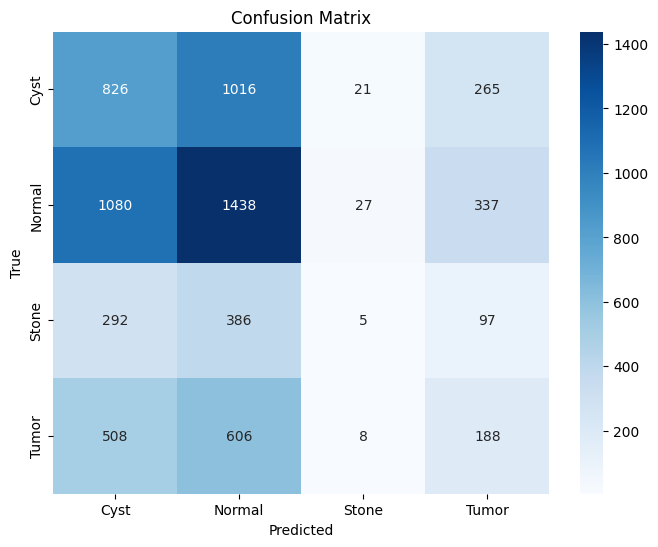

In [17]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the test set
predictions = model.predict(test_generator, batch_size=BATCH_SIZE)
predictions = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Calculated Precision, Recall & F1 Score for EfficientNetB0:

In [22]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predictions and Metrics
y_true = train_generator.classes
y_pred_probs = model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

778/778 [==============================] - 4471s 6s/step
Precision: 0.16640054083939906
Recall: 0.40792222400771333
F1 Score: 0.23637746176877938


C:\Users\dheer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Mean pixel intensity graph for Each class:

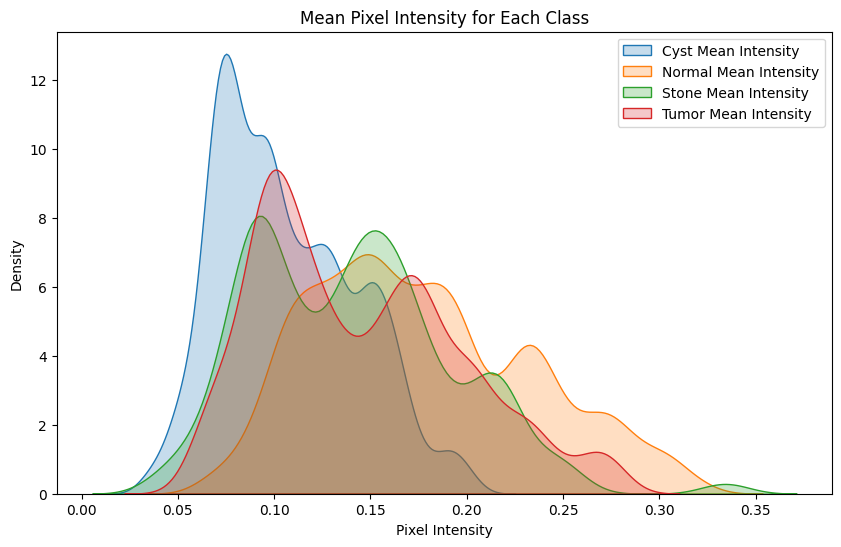

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Initialize dictionary to store mean pixel intensity for each class
class_intensity = {class_name: [] for class_name in train_generator.class_indices.keys()}

# Loop through the dataset
for class_name, class_index in train_generator.class_indices.items():
    class_images = [
        img_to_array(load_img(file_path, target_size=(img_height, img_width))) / 255.0
        for file_path, label in zip(train_generator.filepaths, train_generator.classes)
        if label == class_index
    ]
    # Calculate mean pixel intensity for this class
    mean_intensity = [np.mean(image) for image in class_images]
    class_intensity[class_name] = mean_intensity

# Plot mean pixel intensity per class
plt.figure(figsize=(10, 6))
for class_name, intensities in class_intensity.items():
    sns.kdeplot(intensities, label=f"{class_name} Mean Intensity", fill=True)

plt.title("Mean Pixel Intensity for Each Class")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.legend()
plt.show()


# Experiment No 1: MobileNetV2

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset paths
train_dir = './ct_kidney/split_dataset/train'
val_dir = './ct_kidney/split_dataset/validation'
test_dir = './ct_kidney/split_dataset/test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

# Build Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
print("Training MobileNetV2...")
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Evaluate Model

print("Evaluating MobileNetV2...")
loss, accuracy = model.evaluate(test_generator)
print(f"MobileNetV2 - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Found 12446 images belonging to 4 classes.
Found 7669 images belonging to 4 classes.
Found 6485 images belonging to 4 classes.
Training MobileNetV2...
Epoch 1/10
389/389 [==============================] - 1439s 4s/step - loss: 0.1708 - accuracy: 0.9368 - val_loss: 0.5886 - val_accuracy: 0.8056
Epoch 2/10
389/389 [==============================] - 2207s 6s/step - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.8428 - val_accuracy: 0.8006
Epoch 3/10
389/389 [==============================] - 1405s 4s/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.1949 - val_accuracy: 0.9411
Epoch 4/10
389/389 [==============================] - 1144s 3s/step - loss: 0.0130 - accuracy: 0.9958 - val_loss: 0.0869 - val_accuracy: 0.9692
Epoch 5/10
389/389 [==============================] - 1420s 4s/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.5597 - val_accuracy: 0.8782
Epoch 6/10
389/389 [==============================] - 3581s 9s/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 0.1302 - val_ac

# Classification report for MobileNetV2:

In [15]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test data
y_true = train_generator.classes  # Ground truth labels
y_pred_prob = model.predict(train_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to predicted classes

# Get class indices to match labels with their names
class_labels = list(train_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)


389/389 [==============================] - 217s 558ms/step
              precision    recall  f1-score   support

        Cyst     0.2943    0.3486    0.3192      3709
      Normal     0.4063    0.5208    0.4565      5077
       Stone     0.1163    0.0073    0.0137      1377
       Tumor     0.1933    0.1235    0.1507      2283

    accuracy                         0.3398     12446
   macro avg     0.2525    0.2500    0.2350     12446
weighted avg     0.3018    0.3398    0.3105     12446



# Test Accuracy & Loss:

In [24]:

# Evaluate on test set


test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

222/222 [==============================] - 130s 586ms/step - loss: 0.6547 - accuracy: 0.8258
Test Loss: 0.6547276377677917
Test Accuracy: 0.8257746696472168


# Plot the loss and accuracy curves for MobileNetV2:

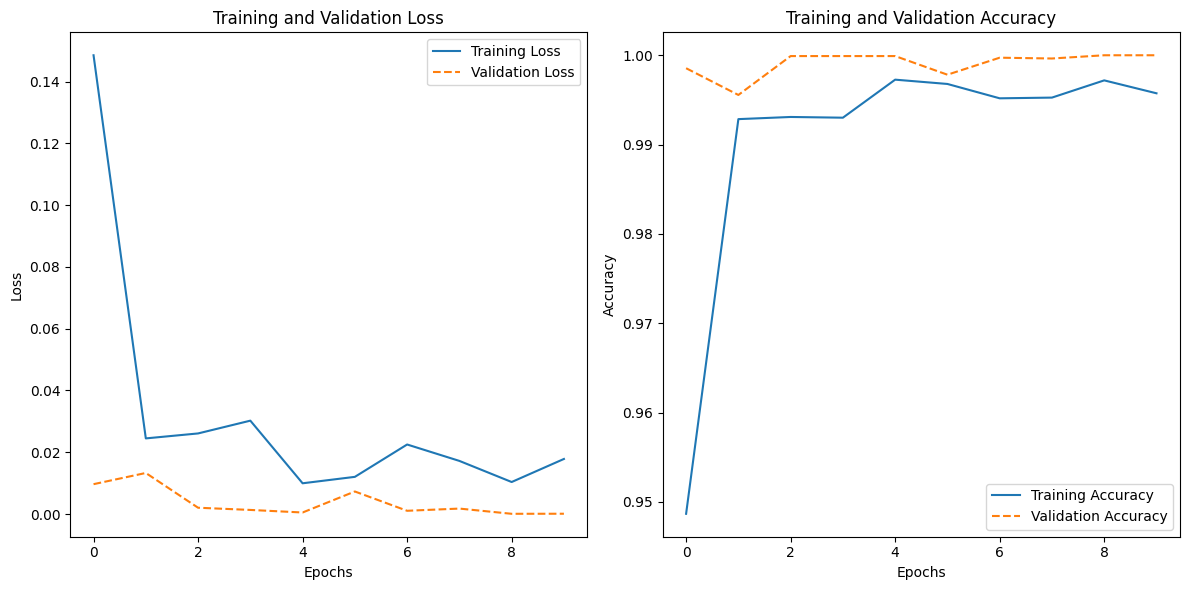

In [73]:
import matplotlib.pyplot as plt

# Extracting training and validation metrics from history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Experiment No 2: ResNet50

In [74]:
from tensorflow.keras.applications import ResNet50
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Build Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
print("Training ResNet50...")
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Evaluate Model
print("Evaluating ResNet50...")
loss, accuracy = model.evaluate(test_generator)
print(f"ResNet50 - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Training ResNet50...
Epoch 1/10
778/778 [==============================] - 4165s 5s/step - loss: 0.1037 - accuracy: 0.9650 - val_loss: 2.1419 - val_accuracy: 0.4741
Epoch 2/10
778/778 [==============================] - 4603s 6s/step - loss: 0.0331 - accuracy: 0.9903 - val_loss: 0.0296 - val_accuracy: 0.9905
Epoch 3/10
778/778 [==============================] - 4518s 6s/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0209 - val_accuracy: 0.9936
Epoch 4/10
778/778 [==============================] - 20616s 27s/step - loss: 0.0111 - accuracy: 0.9969 - val_loss: 1.2002e-04 - val_accuracy: 1.0000
Epoch 5/10
778/778 [==============================] - 23338s 30s/step - loss: 1.6481e-04 - accuracy: 1.0000 - val_loss: 2.4613e-06 - val_accuracy: 1.0000
Epoch 6/10
778/778 [==============================] - 4813s 6s/step - loss: 0.0362 - accuracy: 0.9905 - val_loss: 0.0016 - val_accuracy: 0.9998
Epoch 7/10
778/778 [==============================] - 3975s 5s/step - loss: 0.0073 - accuracy: 0.99

# Classification report for ResNet50:

In [8]:
import tensorflow as tf

def weighted_categorical_crossentropy(class_weights):
    """
    A weighted version of categorical cross-entropy
    """
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Scale predictions so that the sum of probabilities is 1
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        # Clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # Compute cross-entropy loss
        loss = -y_true * tf.math.log(y_pred) * class_weights
        return tf.reduce_sum(loss, axis=-1)

    return loss


In [9]:
class_counts = [3709, 2283, 1377, 5077]  # Number of samples per class
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]


In [10]:
# Calculate class weights
class_weights = [0.612, 0.990, 1.640, 0.444]  # Example weights (adjust based on dataset)

# Define custom loss
loss = weighted_categorical_crossentropy(class_weights)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=['accuracy'])


In [12]:
history = model.fit(train_generator, validation_data=val_generator, epochs=1)


389/389 [==============================] - 1290s 3s/step - loss: 0.1502 - accuracy: 0.9272 - val_loss: 0.6516 - val_accuracy: 0.8272


In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test data
y_true = train_generator.classes  # Ground truth labels
y_pred_prob = model.predict(train_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to predicted classes

# Get class indices to match labels with their names
class_labels = list(train_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)


389/389 [==============================] - 217s 555ms/step
              precision    recall  f1-score   support

        Cyst     0.2911    0.3440    0.3154      3709
      Normal     0.4081    0.5267    0.4599      5077
       Stone     0.1111    0.0073    0.0136      1377
       Tumor     0.1985    0.1235    0.1523      2283

    accuracy                         0.3408     12446
   macro avg     0.2522    0.2504    0.2353     12446
weighted avg     0.3019    0.3408    0.3110     12446



# Confusion Matrix:

222/222 [==============================] - 119s 534ms/step


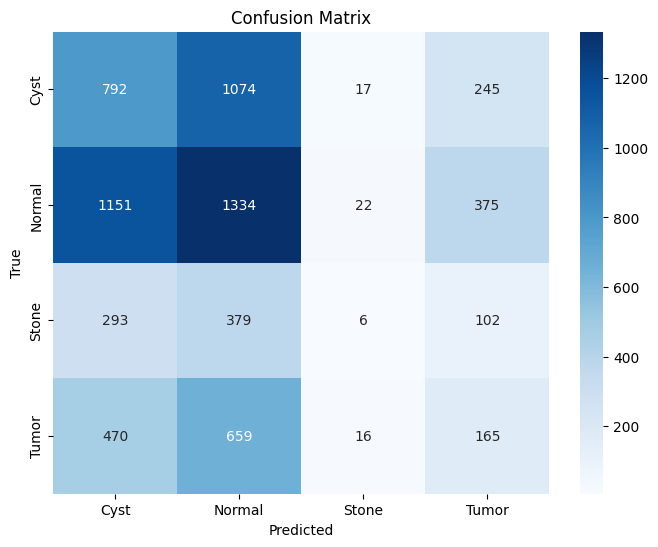

In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the test set
predictions = model.predict(test_generator, batch_size=BATCH_SIZE)
predictions = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Plot the loss and accuracy curves for ResNetN50

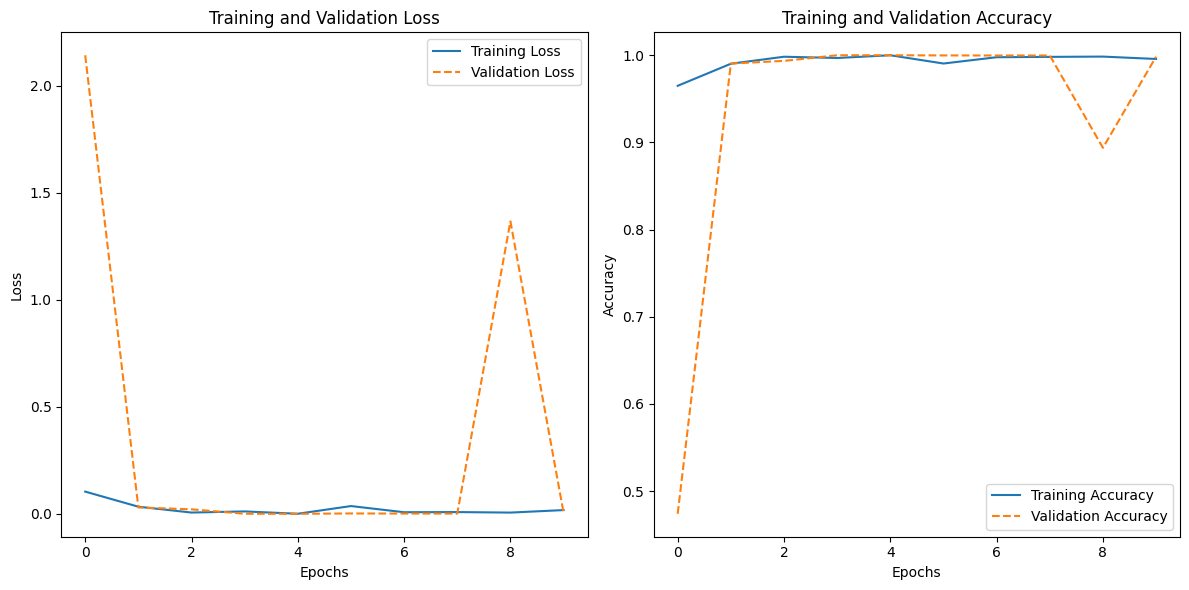

In [76]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from the training history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot the training loss curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Test Accuracy & Loss:

In [77]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


222/222 [==============================] - 325s 1s/step - loss: 0.0046 - accuracy: 0.9982
Test Loss: 0.0046
Test Accuracy: 0.9982


# Experiment No 3: InceptionV3

In [27]:
from tensorflow.keras.applications import InceptionV3
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Build Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])


# Train Model
print("Training InceptionV3...")
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Evaluate Model
print("Evaluating InceptionV3...")
loss, accuracy = model.evaluate(test_generator)
print(f"InceptionV3 - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Training InceptionV3...
Epoch 1/10
778/778 [==============================] - 3561s 5s/step - loss: 0.1485 - accuracy: 0.9487 - val_loss: 0.0097 - val_accuracy: 0.9985
Epoch 2/10
778/778 [==============================] - 2556s 3s/step - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0133 - val_accuracy: 0.9956
Epoch 3/10
778/778 [==============================] - 2529s 3s/step - loss: 0.0261 - accuracy: 0.9931 - val_loss: 0.0020 - val_accuracy: 0.9999
Epoch 4/10
778/778 [==============================] - 2472s 3s/step - loss: 0.0302 - accuracy: 0.9930 - val_loss: 0.0013 - val_accuracy: 0.9999
Epoch 5/10
778/778 [==============================] - 2532s 3s/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 5.0867e-04 - val_accuracy: 0.9999
Epoch 6/10
778/778 [==============================] - 2528s 3s/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.0073 - val_accuracy: 0.9978
Epoch 7/10
778/778 [==============================] - 4001s 5s/step - loss: 0.0225 - accuracy: 0.9952 - val_

# Plot the loss and accuracy curves for InceptionV3

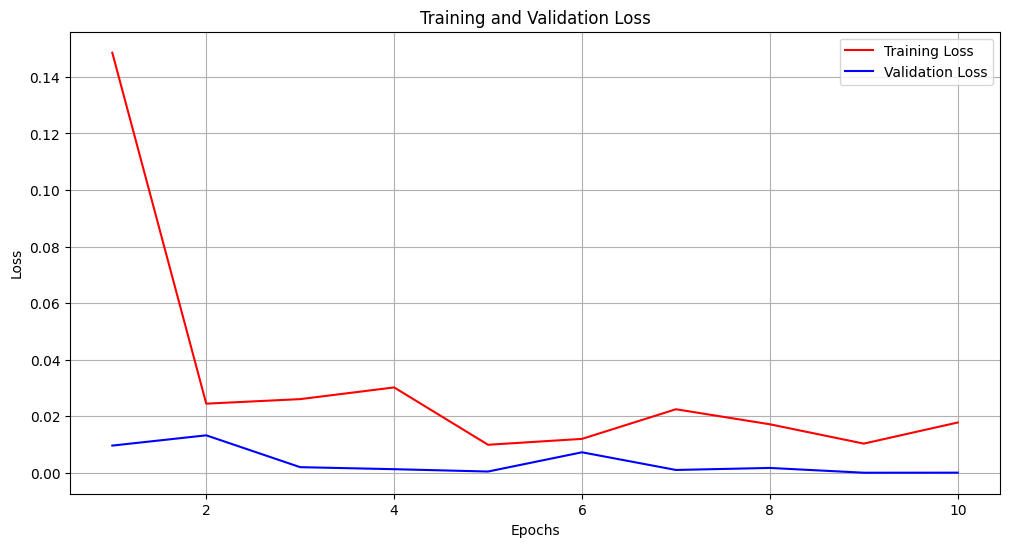

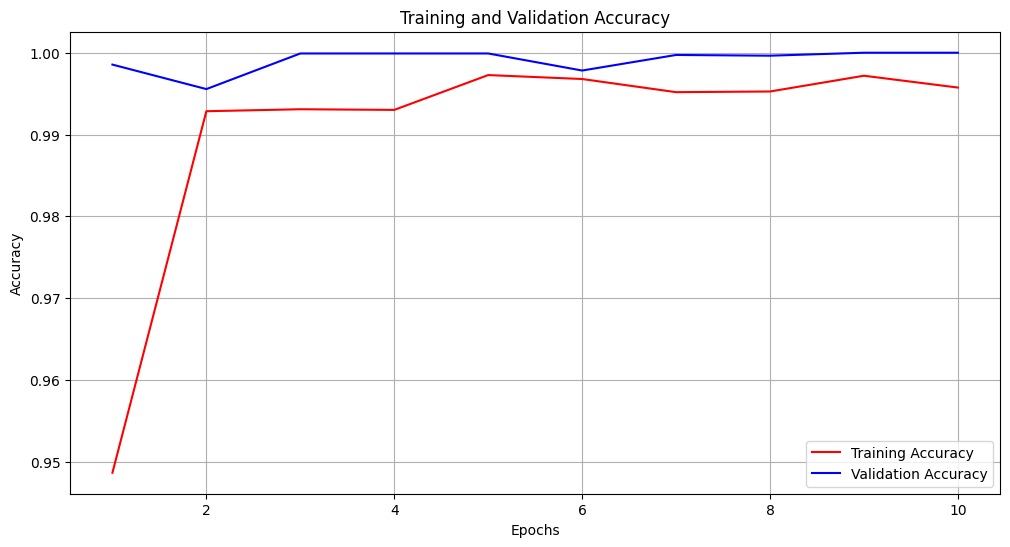

In [28]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Define the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot Loss Curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Test Accuracy for InceptionV3

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


444/444 [==============================] - 194s 436ms/step - loss: 1.0157e-04 - accuracy: 1.0000
Test Loss: 0.0001
Test Accuracy: 1.0000


# Classification report for InceptionV3:

In [14]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test data
y_true = train_generator.classes  # Ground truth labels
y_pred_prob = model.predict(train_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to predicted classes

# Get class indices to match labels with their names
class_labels = list(train_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)


389/389 [==============================] - 214s 550ms/step
              precision    recall  f1-score   support

        Cyst     0.2995    0.3564    0.3255      3709
      Normal     0.4071    0.5200    0.4567      5077
       Stone     0.1261    0.0102    0.0188      1377
       Tumor     0.1741    0.1095    0.1344      2283

    accuracy                         0.3395     12446
   macro avg     0.2517    0.2490    0.2339     12446
weighted avg     0.3012    0.3395    0.3100     12446



# Grad-CAM Implementation :

In [33]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

def plot_gradcam(model, img, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    gradcam = np.sum(weights * conv_outputs[0], axis=-1)
    gradcam = np.maximum(gradcam, 0) / np.max(gradcam)
    plt.imshow(gradcam, cmap='jet', alpha=0.5)


In [33]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

def plot_gradcam(model, img, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img, axis=0))
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    gradcam = np.sum(weights * conv_outputs[0], axis=-1)
    gradcam = np.maximum(gradcam, 0) / np.max(gradcam)
    plt.imshow(gradcam, cmap='jet', alpha=0.5)


for layer in model.layers:
    print(layer.name)


# Visualize Image using Grad-CAM:

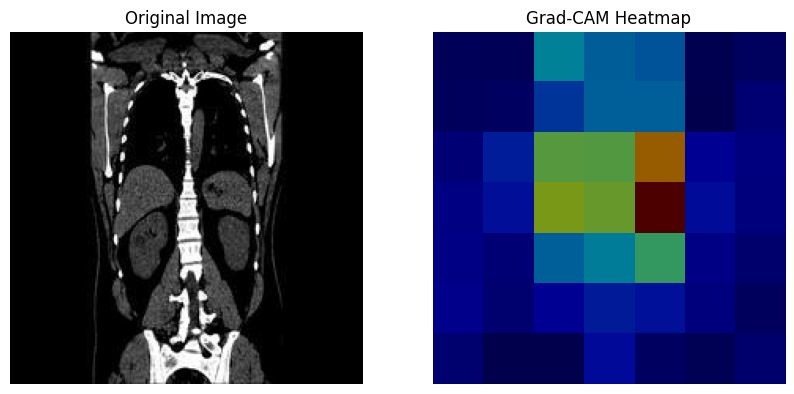

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Load the EfficientNetB0 model with pre-trained weights
model = EfficientNetB0(weights='imagenet')

# Preprocessing function for EfficientNetB0
def preprocess_input(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Preprocessing for EfficientNetB0
    return img_array

# Grad-CAM function
def grad_cam(model, img, layer_name="top_activation"):
    # Create a model that outputs the activations of the selected convolutional layer and the model's prediction
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    # Compute the gradients of the output class with respect to the selected layer's output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, np.argmax(predictions[0])]  # Get the class of highest probability
    grads = tape.gradient(loss, conv_outputs)

    # Compute the weights for each channel (importance of each feature map)
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average gradients over the spatial dimensions

    # Create the Grad-CAM heatmap by weighting the feature maps by the computed weights
    gradcam = np.dot(conv_outputs[0], weights.numpy())
    gradcam = np.maximum(gradcam, 0)  # ReLU activation
    gradcam = gradcam / np.max(gradcam)  # Normalize the heatmap

    return gradcam

# Visualize Grad-CAM
def display_gradcam(img_path, gradcam):
    img = image.load_img(img_path, target_size=(224, 224))
    img = np.array(img)

    plt.figure(figsize=(10, 10))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    # Grad-CAM heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(gradcam, cmap='jet', alpha=0.6)  # Overlay heatmap
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.show()

# Main
img_path = "./ct_kidney/split_dataset/train/Cyst/Cyst- (50).jpg"  #  image path
img_array = preprocess_input(img_path)
gradcam = grad_cam(model, img_array, layer_name="top_activation")  # 'top_activation' is one of the last layers
display_gradcam(img_path, gradcam)


# Grad-CAM Superimposed Image Implementation :

In [1]:
! pip install tensorflow matplotlib

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.20.0 requires typing_extensions>=4.9.0, but you have typing-extensions 4.5.0 which is incompatible.
sqlalchemy 2.0.25 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
torch 2.5.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.
torchaudio 2.0.2+cu117 requires torch==2.0.1, but you have torch 2.5.1 which is incompatible.


# Grad-CAM Superimposed Image Implementation for Cyst:

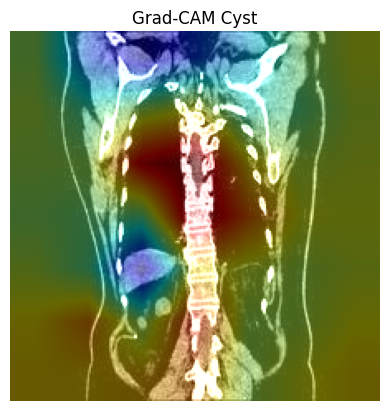

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, InceptionV3, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Example: Load EfficientNetB0 model
model = EfficientNetB0(weights='imagenet')  

# Load and preprocess the image
img_path = './ct_kidney/split_dataset/train/Cyst/Cyst- (1).jpg'  # Image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize image for model input
img_array = image.img_to_array(img)  # Convert image to array
img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess for the model, for example using EfficientNetB0 preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input
img_array = preprocess_input(img_array)


def grad_cam(model, img_array, layer_name='top_conv'):  # Use 'top_conv' for EfficientNetB0
    grad_model = Model(inputs=model.input, outputs=[model.output, model.get_layer(layer_name).output])
    with tf.GradientTape() as tape:
        model_out, conv_out = grad_model(img_array)
        class_idx = np.argmax(model_out[0])  # Get the predicted class index
        class_out = model_out[:, class_idx]
    
    # Compute gradients of the predicted class with respect to the convolutional layer
    grads = tape.gradient(class_out, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling
    
    # Multiply the gradients with the conv output feature map
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_out), axis=-1)
    
    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # Resize the heatmap to the size of the input image
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))  # No need for .numpy()
    return heatmap


def display_grad_cam(img, heatmap):
    # Convert the image to RGB and normalize
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (224, 224))
    
    # Apply the heatmap to the image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose the heatmap on the image
    superimposed_img = heatmap * 0.4 + img  # Adjust opacity if needed
    superimposed_img = np.uint8(np.clip(superimposed_img, 0, 255))
    
    # Display the image
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Cyst")
    plt.show()

# Generate Grad-CAM heatmap
heatmap = grad_cam(model, img_array)

# Display Grad-CAM result
display_grad_cam(img, heatmap)


# Grad-CAM Superimposed Image Implementation for Stone:

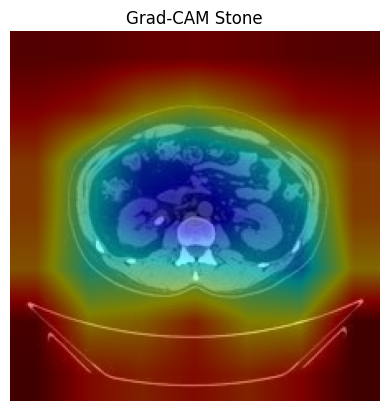

In [37]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Define Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        heatmap = torch.sum(weights * self.activation, dim=1).squeeze()
        heatmap = torch.relu(heatmap)
        heatmap = heatmap / torch.max(heatmap)
        return heatmap.cpu().detach().numpy()

# Load model and define Grad-CAM
model = models.efficientnet_b0(pretrained=True)  # Example model
model.eval()
target_layer = model.features[-1]  # Adjust for your model
gradcam = GradCAM(model, target_layer)

# Process input image
image = cv2.imread('./ct_kidney/split_dataset/train/Stone/Stone- (1).jpg')  # Example CT image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Generate heatmap
output = model(input_tensor)
class_idx = torch.argmax(output, dim=1).item()
model.zero_grad()
output[:, class_idx].backward()
heatmap = gradcam.generate_heatmap(class_idx)

# Overlay heatmap on the image
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

# Display
plt.imshow(overlay)
plt.title("Grad-CAM Stone")
plt.axis('off')
plt.show()


# Grad-CAM Superimposed Image Implementation for Tumor:

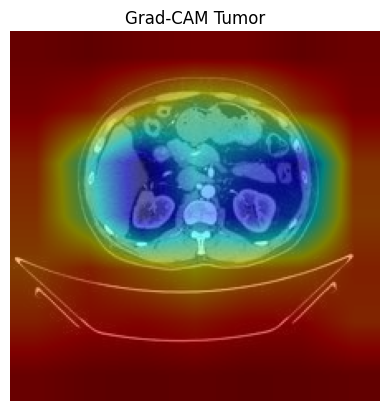

In [47]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Define Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        heatmap = torch.sum(weights * self.activation, dim=1).squeeze()
        heatmap = torch.relu(heatmap)
        heatmap = heatmap / torch.max(heatmap)
        return heatmap.cpu().detach().numpy()

# Load model and define Grad-CAM
model = models.efficientnet_b0(pretrained=True)  # Example model
model.eval()
target_layer = model.features[-1]  # Adjust for your model
gradcam = GradCAM(model, target_layer)

# Process input image
image = cv2.imread('./ct_kidney/split_dataset/train/Tumor/Tumor- (3).jpg')  # Example CT image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Generate heatmap
output = model(input_tensor)
class_idx = torch.argmax(output, dim=1).item()
model.zero_grad()
output[:, class_idx].backward()
heatmap = gradcam.generate_heatmap(class_idx)

# Overlay heatmap on the image
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

# Display
plt.imshow(overlay)
plt.title("Grad-CAM Tumor")
plt.axis('off')
plt.show()


# Grad-CAM Superimposed Image Implementation for Normal:

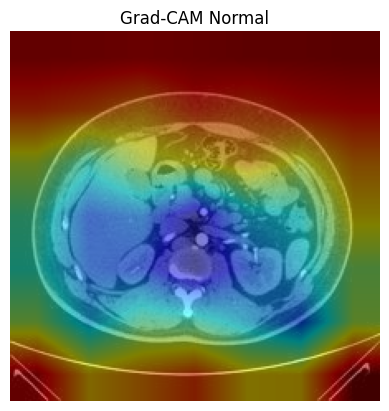

In [50]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

# Define Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activation = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        heatmap = torch.sum(weights * self.activation, dim=1).squeeze()
        heatmap = torch.relu(heatmap)
        heatmap = heatmap / torch.max(heatmap)
        return heatmap.cpu().detach().numpy()

# Load model and define Grad-CAM
model = models.efficientnet_b0(pretrained=True)  # Example model
model.eval()
target_layer = model.features[-1]  # Adjust for your model
gradcam = GradCAM(model, target_layer)

# Process input image
image = cv2.imread('./ct_kidney/split_dataset/train/Normal/Normal- (30).jpg')  # Example CT image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)

# Generate heatmap
output = model(input_tensor)
class_idx = torch.argmax(output, dim=1).item()
model.zero_grad()
output[:, class_idx].backward()
heatmap = gradcam.generate_heatmap(class_idx)

# Overlay heatmap on the image
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image, 0.5, heatmap_colored, 0.5, 0)

# Display
plt.imshow(overlay)
plt.title("Grad-CAM Normal")
plt.axis('off')
plt.show()


# graphs comparing the final performance metrics of all models

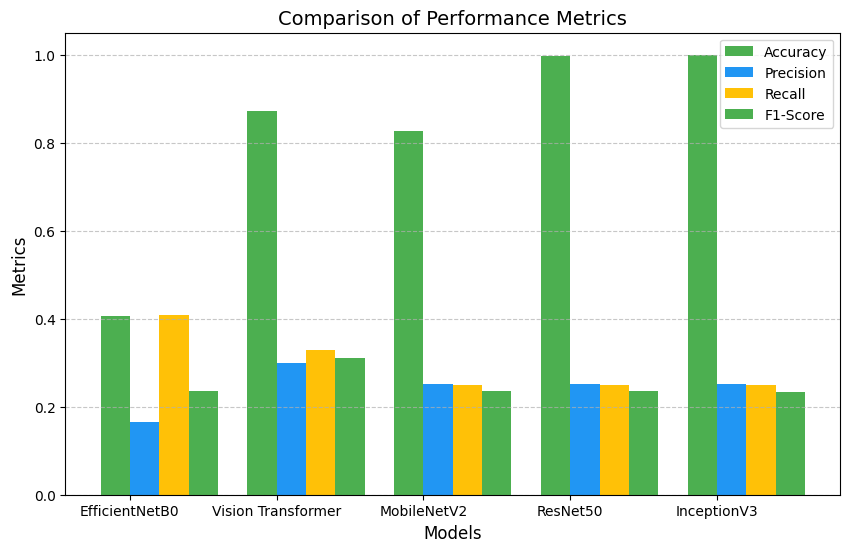

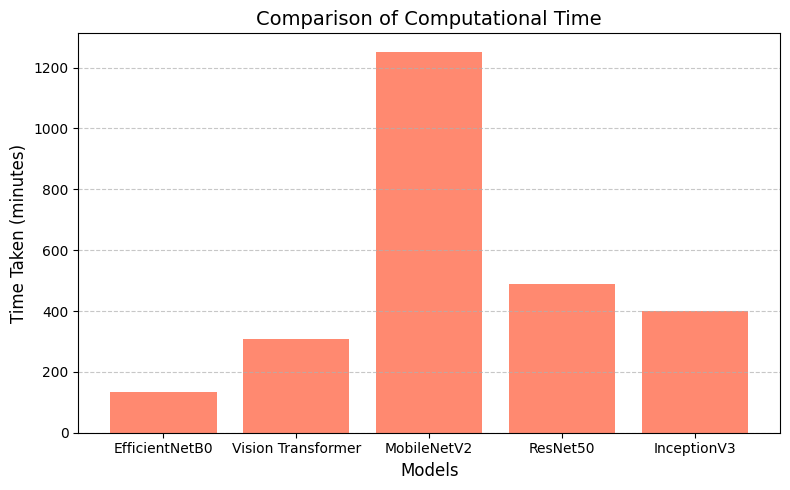

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with actual results)
models = ['EfficientNetB0', 'Vision Transformer', 'MobileNetV2','ResNet50','InceptionV3']
accuracy = [0.4059, 0.8732, 0.8258,0.9982,1.000,]
precision = [0.1664, 0.30, 0.2525,0.2522,0.2517]
recall = [0.4079, 0.33, 0.2500, 0.2504,0.2490]
f1_score = [0.2364, 0.31, 0.2350, 0.2353, 0.2339]
time_taken = [135, 309, 1250, 490, 401]  # Time in minutes

# Create a grouped bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
data = [accuracy, precision, recall, f1_score]
colors = ['#4CAF50', '#2196F3', '#FFC107']

x = np.arange(len(models))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric
for i, metric in enumerate(data):
    ax.bar(x + i * width, metric, width, label=metrics[i], color=colors[i % len(colors)])

# Format the chart
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Metrics', fontsize=12)
ax.set_title('Comparison of Performance Metrics', fontsize=14)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Computational time as a separate chart
fig, ax2 = plt.subplots(figsize=(8, 5))
ax2.bar(models, time_taken, color='#FF5733', alpha=0.7)
ax2.set_xlabel('Models', fontsize=12)
ax2.set_ylabel('Time Taken (minutes)', fontsize=12)
ax2.set_title('Comparison of Computational Time', fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Display the charts
plt.tight_layout()
plt.show()
